<a href="https://colab.research.google.com/github/tylergusmyers/ML_token_prices/blob/main/BTC_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Required libraries** 

In [12]:
# Install the required libraries
from IPython.display import clear_output
try:
  #!pip install pystan
  !pip install pytrends
  !pip install yfinance
  !pip install yahoofinancials
except:
  print("Error installing libraries")
finally:
  clear_output()
  print('Libraries successfully installed')

Libraries successfully installed


In [14]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error
#from sklearn.preprocessing import StandardScaler,OneHotEncoder
from pathlib import Path
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report


#import yfinance as yf
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pytrends.request import TrendReq


**Step 1 get BTC-USD tiker from Yahoo Finance to Pandas DataFrame**

In [124]:
# Upload BitCoin historical data from Yahoo finance and load into Pandas DataFrame 
btc = yf.Ticker("BTC-USD")

# get historical market data
btc_usd_df = btc.history(
                          start='2017-01-01', 
                      end='2022-01-20', 
                      progress=False,
)


display(btc_usd_df.head())
display(btc_usd_df.tail())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,147775008,0,0
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,222184992,0,0
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,185168000,0,0
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,344945984,0,0
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,510199008,0,0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-16,43172.039062,43436.808594,42691.023438,43113.878906,17902097845,0,0
2022-01-17,43118.121094,43179.390625,41680.320312,42250.550781,21690904261,0,0
2022-01-18,42250.074219,42534.402344,41392.214844,42375.632812,22417209227,0,0
2022-01-19,42374.039062,42478.304688,41242.914062,41744.328125,23091543258,0,0
2022-01-20,41736.527344,43381.250000,41724.464844,42766.710938,17167265792,0,0


In [125]:
# Drop columns "Dividens" and "Stocks Splits" as they are not relevant to crypto coins
btc_usd_df = btc_usd_df.drop(["Dividends", "Stock Splits"], axis=1)


In [126]:
# Filter the date index and close columns

signals_df = btc_usd_df.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns
Date,,
2017-01-02,1021.750000,0.023464
2017-01-03,1043.839966,0.021620
2017-01-04,1154.729980,0.106233
2017-01-05,1013.380005,-0.122410
2017-01-06,902.200989,-0.109711


,Close,Actual Returns
Date,,
2022-01-16,43113.878906,-0.001471
2022-01-17,42250.550781,-0.020024
2022-01-18,42375.632812,0.002960
2022-01-19,41744.328125,-0.014898
2022-01-20,42766.710938,0.024492


**Step 2 Generate trading signals using short- and long windo SMA values**

In [127]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2017-04-11,1205.010010,0.015062,1188.989990,1048.253910
2017-04-12,1200.369995,-0.003851,1195.095001,1050.040110
2017-04-13,1169.280029,-0.025900,1190.447510,1051.294510
2017-04-14,1167.540039,-0.001488,1185.550018,1051.422611
2017-04-15,1172.520020,0.004265,1177.427521,1053.014011


,Close,Actual Returns,SMA_Fast,SMA_Slow
Date,,,,
2022-01-16,43113.878906,-0.001471,42995.636719,54330.937227
2022-01-17,42250.550781,-0.020024,42910.381836,54203.760508
2022-01-18,42375.632812,0.002960,42729.365234,54079.801055
2022-01-19,41744.328125,-0.014898,42371.097656,53922.396445
2022-01-20,42766.710938,0.024492,42284.305664,53789.652969


In [128]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2017-04-11,1205.010010,0.015062,1188.989990,1048.253910,1.0
2017-04-12,1200.369995,-0.003851,1195.095001,1050.040110,-1.0
2017-04-13,1169.280029,-0.025900,1190.447510,1051.294510,-1.0
2017-04-14,1167.540039,-0.001488,1185.550018,1051.422611,-1.0
2017-04-15,1172.520020,0.004265,1177.427521,1053.014011,1.0


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal
Date,,,,,
2022-01-16,43113.878906,-0.001471,42995.636719,54330.937227,-1.0
2022-01-17,42250.550781,-0.020024,42910.381836,54203.760508,-1.0
2022-01-18,42375.632812,0.002960,42729.365234,54079.801055,1.0
2022-01-19,41744.328125,-0.014898,42371.097656,53922.396445,-1.0
2022-01-20,42766.710938,0.024492,42284.305664,53789.652969,1.0


In [129]:
signals_df['Signal'].value_counts()

 1.0    939
-1.0    807
Name: Signal, dtype: int64

In [130]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2017-04-11,1205.010010,0.015062,1188.989990,1048.253910,1.0,NaN
2017-04-12,1200.369995,-0.003851,1195.095001,1050.040110,-1.0,-0.003851
2017-04-13,1169.280029,-0.025900,1190.447510,1051.294510,-1.0,0.025900
2017-04-14,1167.540039,-0.001488,1185.550018,1051.422611,-1.0,0.001488
2017-04-15,1172.520020,0.004265,1177.427521,1053.014011,1.0,-0.004265


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-01-16,43113.878906,-0.001471,42995.636719,54330.937227,-1.0,-0.001471
2022-01-17,42250.550781,-0.020024,42910.381836,54203.760508,-1.0,0.020024
2022-01-18,42375.632812,0.002960,42729.365234,54079.801055,1.0,-0.002960
2022-01-19,41744.328125,-0.014898,42371.097656,53922.396445,-1.0,-0.014898
2022-01-20,42766.710938,0.024492,42284.305664,53789.652969,1.0,-0.024492


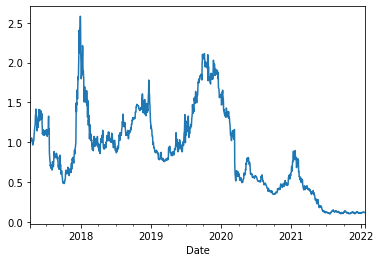

In [131]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

**Step 3 Splitting data into training and testing**

In [132]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()


,SMA_Fast,SMA_Slow
Date,,
2017-04-12,1188.989990,1048.253910
2017-04-13,1195.095001,1050.040110
2017-04-14,1190.447510,1051.294510
2017-04-15,1185.550018,1051.422611
2017-04-16,1177.427521,1053.014011


In [133]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    939
-1.0    807
Name: Signal, dtype: int64

In [134]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)



2017-04-12 00:00:00


In [135]:
# Select the ending period for the training data with an offset of 3 months 
training_end = X.index.min() + DateOffset(months=48)


#training_end = pd.to_datetime(training_end, format="%y%y%yy-%m%m-%d%d")
# Display the training end date
print(training_end)

2021-04-12 00:00:00


In [136]:
# Training signal Dataframe
signals_training_df = signals_df.loc[training_begin.to_pydatetime() :training_end.to_pydatetime() ]
display(signals_training_df.head())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2017-04-12,1200.369995,-0.003851,1195.095001,1050.040110,-1.0,-0.003851
2017-04-13,1169.280029,-0.025900,1190.447510,1051.294510,-1.0,0.025900
2017-04-14,1167.540039,-0.001488,1185.550018,1051.422611,-1.0,0.001488
2017-04-15,1172.520020,0.004265,1177.427521,1053.014011,1.0,-0.004265
2017-04-16,1182.939941,0.008887,1173.070007,1055.821401,1.0,0.008887


In [137]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
display(X_train.head())
#display(X_train.tail())



,SMA_Fast,SMA_Slow
Date,,
2017-04-12,1188.989990,1048.253910
2017-04-13,1195.095001,1050.040110
2017-04-14,1190.447510,1051.294510
2017-04-15,1185.550018,1051.422611
2017-04-16,1177.427521,1053.014011


In [158]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.head())
display(X_test.tail())


,SMA_Fast,SMA_Slow
Date,,
2021-04-13,59534.164062,47222.407207
2021-04-14,60848.777344,47529.621543
2021-04-15,61677.892578,47840.999355
2021-04-16,62455.154297,48134.215176
2021-04-17,62874.988281,48381.699434


,SMA_Fast,SMA_Slow
Date,,
2022-01-16,43204.442383,54439.476914
2022-01-17,42995.636719,54330.937227
2022-01-18,42910.381836,54203.760508
2022-01-19,42729.365234,54079.801055
2022-01-20,42371.097656,53922.396445


In [139]:
# Test signal Dataframe

signals_test_df = signals_df.loc[(training_end + DateOffset(hours=1)).to_pydatetime() : ]
display(signals_test_df.head())
display(signals_test_df.tail())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2021-04-13,63503.457031,0.060274,60848.777344,47529.621543,1.0,-0.060274
2021-04-14,63109.695312,-0.006201,61677.892578,47840.999355,-1.0,-0.006201
2021-04-15,63314.011719,0.003237,62455.154297,48134.215176,1.0,-0.003237
2021-04-16,61572.789062,-0.027501,62874.988281,48381.699434,-1.0,-0.027501
2021-04-17,60683.820312,-0.014438,62170.079102,48594.827207,-1.0,0.014438


,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2022-01-16,43113.878906,-0.001471,42995.636719,54330.937227,-1.0,-0.001471
2022-01-17,42250.550781,-0.020024,42910.381836,54203.760508,-1.0,0.020024
2022-01-18,42375.632812,0.002960,42729.365234,54079.801055,1.0,-0.002960
2022-01-19,41744.328125,-0.014898,42371.097656,53922.396445,-1.0,-0.014898
2022-01-20,42766.710938,0.024492,42284.305664,53789.652969,1.0,-0.024492


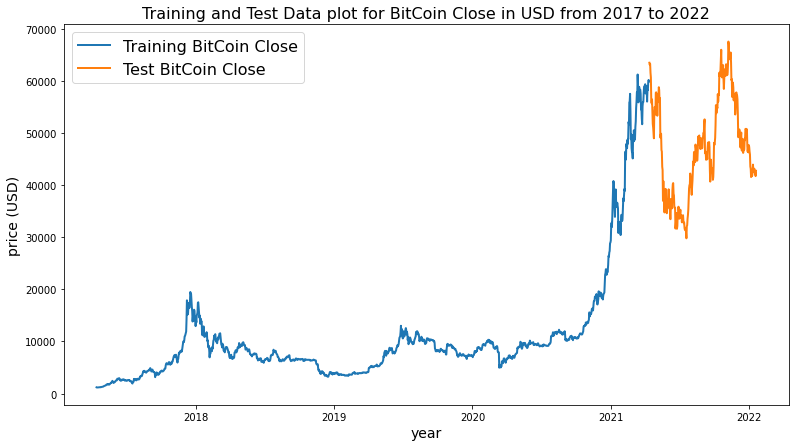

In [140]:
# Function to plot the test dataset and trainig dataset into a line

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price (USD)', fontsize=14)
    ax.set_xlabel('year', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

# Display the line chart of the line plot for both the trainig and the test data set   

line_plot(signals_training_df["Close"], signals_test_df["Close"], 'Training BitCoin Close', 'Test BitCoin Close', title='Training and Test Data plot for BitCoin Close in USD from 2017 to 2022')

In [141]:
# Review the y_test DataFrame
display(y_test.head())
display(y_test.tail())

Date
2021-04-13    1.0
2021-04-14   -1.0
2021-04-15    1.0
2021-04-16   -1.0
2021-04-17   -1.0
Name: Signal, dtype: float64

Date
2022-01-16   -1.0
2022-01-17   -1.0
2022-01-18    1.0
2022-01-19   -1.0
2022-01-20    1.0
Name: Signal, dtype: float64

In [142]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [162]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_train_scaled)

# Review the model's predicted values
svm_pred[:]

array([1., 1., 1., ..., 1., 1., 1.])

In [172]:
# Evaluate the model using a classification report
svm_training_report = classification_report(y_train, svm_pred)
print(svm_training_report)


              precision    recall  f1-score   support

        -1.0       1.00      0.01      0.01       664
         1.0       0.55      1.00      0.71       798

    accuracy                           0.55      1462
   macro avg       0.77      0.50      0.36      1462
weighted avg       0.75      0.55      0.39      1462



In [173]:
# Use the trained model to predict the trading signals for the testing data.
svm_testing_predictions = svm_model.predict(X_test_scaled)


In [175]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_testing_predictions)

# Print the classification report
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       143
         1.0       0.49      1.00      0.66       140

    accuracy                           0.49       283
   macro avg       0.25      0.50      0.33       283
weighted avg       0.24      0.49      0.33       283



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [177]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)


# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_testing_predictions

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']


# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Predicted'] * predictions_df['Actual Returns']


# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
Date,,,
2021-04-13,1.0,0.060274,0.060274
2021-04-14,1.0,-0.006201,-0.006201
2021-04-15,1.0,0.003237,0.003237
2021-04-16,1.0,-0.027501,-0.027501
2021-04-17,1.0,-0.014438,-0.014438


,Predicted,Actual Returns,Strategy Returns
Date,,,
2022-01-16,1.0,-0.001471,-0.001471
2022-01-17,1.0,-0.020024,-0.020024
2022-01-18,1.0,0.002960,0.002960
2022-01-19,1.0,-0.014898,-0.014898
2022-01-20,1.0,0.024492,0.024492


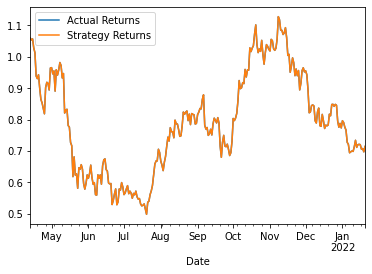

In [178]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()